**Developing an Image Classifier Application**

In this project, we will train an image classifier to recognize different species of dishes. You can imagine using something like this in a phone app that tells you the name of the dish your camera is looking at. In practice you had train this classifier, then export it for use in your application. We will be using this dataset of 231 dish categories, you can see a few examples below.

The project is broken down into multiple steps:

*   **Load and preprocess the image dataset**
*  **Train the image classifier on your dataset**
*  **Use the trained classifier to predict image content**



First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.





In [ ]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import os, random
import json
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Load the data**

Here you'll use torchvision to load the data  [(documentation)](https://pytorch.org/docs/0.3.0/torchvision/index.html).The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [ ]:
traindir = '/content/drive/My Drive/Naaniz/Indian Dishes'
#validdir = '/content/drive/My Drive/Train/train/'
def load_split_train_test(datadir, valid_size = .2):
  train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])
  cost_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ])
  test_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                     ])
  # TODO: Load the datasets with ImageFolder
  train_data = datasets.ImageFolder(traindir, transform=train_transforms)
  cost_data = datasets.ImageFolder(traindir, transform=cost_transforms)
  test_data  = datasets.ImageFolder(traindir, transform=test_transforms)

  num_train = len(train_data)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  np.random.shuffle(indices)
  from torch.utils.data.sampler import SubsetRandomSampler
  train_idx, test_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(test_idx)

  trainloader = torch.utils.data.DataLoader(train_data,sampler=train_sampler,batch_size=64)
  valid_loader = torch.utils.data.DataLoader(cost_data,sampler=test_sampler,batch_size=32)
  testloader = torch.utils.data.DataLoader(test_data,sampler=test_sampler,batch_size=32)
  image_datasets = [train_data, cost_data, test_data]
  dataloaders = [trainloader, valid_loader, testloader]
  return image_datasets,dataloaders
 

  
image_datasets,dataloaders = load_split_train_test(traindir, .2)  


# **Label mapping**

You'll also need to load in a mapping from category label to category name. You can find this in the file Naanizdish2.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names of the Dishes.

In [ ]:
import json

with open('/content/drive/My Drive/Naaniz/Naanizdish2.json', 'r') as f:
    cat_to_name = json.load(f)
    
print(cat_to_name)
print("\n Length:", len(cat_to_name))

{'Aloo methi': '1', 'Aloo_Shimala_Mirch': '2', 'Aloo_tikki': '3', 'Amritsari Fish': '4', 'Amritsari_Kulcha': '5', 'Ankuri': '6', 'Attu': '7', 'Baby_corn_chilly': '8', 'Basundi': '9', 'Batata Vada': '10', 'Besan_ke_ladoo': '11', 'Bhakhri': '12', 'Bhindi': '13', 'Boondi_ke_Ladoo': '14', 'Chandrakala': '15', 'Chicken Tikka Masala': '16', 'Corn_Chaat': '17', 'Daal Baati Churma': '18', 'Daal Puri': '19', 'Daal_Makhni': '20', 'Daal_Tadka': '21', 'Dabeli': '22', 'Dibba rotti': '23', 'Everyday Yellow Dal': '24', 'Firni': '25', 'Fish head curry': '26', 'French Bean Aloo': '27', 'Gajar Matar': '28', 'Gajar_Halwa': '29', 'Ghevar': '30', 'Gobhi Matar': '31', 'Hakka Noodles': '32', 'Imarti   Jalebi': '33', 'Kaali_Daal': '34', 'Kadhi Pakora': '35', 'Kalakand': '36', 'Karanji(gujiya)': '37', 'Karela Bharta': '38', 'Lauki_kaufte': '39', 'Litti chokha': '40', 'Malpua': '41', 'Manchurian': '42', 'Mathura ka Peda': '43', 'Medu Vada': '44', 'Milkcake': '45', 'Missi Roti': '46', 'Mix Veg': '47', 'Momos': '

In [ ]:
with open('/content/drive/My Drive/Naaniz/Naanizdish2.json', 'r') as f:
    cat_to_name = json.load(f)

# **Building and training the classifier**
Now that the data is ready, it is time to build and train the classifier. As usual, I will use VGG-19 pretrained models from torchvision.models to get the image features. Build and train a new feed-forward classifier using those features

In [ ]:
# TODO: Build and train your network
# Load a pre-trained network
model = models.vgg19(pretrained=True)
model

for param in model.parameters():
    param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
# Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.# Defin 
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 1024)),
                          ('drop', nn.Dropout(p=0.5)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 231)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
"""#saved_file2 = "/content/drive/My Drive/Colab Notebooks/fulltrained.pth"
model = models.__dict__[args.arch]() # arch is fed as 'vgg16'
model.cuda()
saved_file = "/content/drive/My Drive/Naaniz/checkpointa1.pth"
#checkpointa1 = torch.load(saved_file) # ie, model_best.pth.tar
#model.load(model_fil)
saved_file = "/content/drive/My Drive/Naaniz/checkpointa1.pth"
state_dict = torch.load(saved_file)
#model.load_state_dict(state_dict)"""

'#saved_file2 = "/content/drive/My Drive/Colab Notebooks/fulltrained.pth"\nmodel = models.__dict__[args.arch]() # arch is fed as \'vgg16\'\nmodel.cuda()\nsaved_file = "/content/drive/My Drive/Naaniz/checkpointa1.pth"\n#checkpointa1 = torch.load(saved_file) # ie, model_best.pth.tar\n#model.load(model_fil)\nsaved_file = "/content/drive/My Drive/Naaniz/checkpointa1.pth"\nstate_dict = torch.load(saved_file)\n#model.load_state_dict(state_dict)'

# **Load the saved Model**
The data set we have used consist of 231 classes, so its difficult for me to get one time training accuracy is very well,So for this we save model each and every epoch and  after the completion of epoches we again load the saved model for training. 

In [ ]:
saved_file = "/content/drive/My Drive/epoch/lessloss86%.pth"
state_dict = torch.load(saved_file)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [ ]:
# Train the classifier layers using backpropagation using the pre-trained network to get the features.
# Track the loss and accuracy on the validation set to determine the best hyperparameters.
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

epochs = 5
steps = 0
best=100
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
running_loss = 0
accuracy = 0

start = time.time()
print('Training started')

for e in range(epochs):
    
    train_mode = 0
    valid_mode = 1
    
    for mode in [train_mode, valid_mode]:   
        if mode == train_mode:
            model.train()
        else:
            model.eval()
            
        pass_count = 0
        
        for data in dataloaders[mode]:
            pass_count += 1
            inputs, labels = data
            if cuda == True:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()
            # Forward
            output = model.forward(inputs)
            loss = criterion(output, labels)
            # Backward
            if mode == train_mode:
                loss.backward()
                optimizer.step()                

            running_loss += loss.item()
            ps = torch.exp(output).data
            equality = (labels.data == ps.max(1)[1])
            accuracy = equality.type_as(torch.cuda.FloatTensor()).mean()
        if mode == train_mode:
            print("\nEpoch: {}/{} ".format(e+1, epochs),
                  "\nTraining Loss: {:.4f}  ".format(running_loss/pass_count))
        else:
            print("Validation Loss: {:.4f}  ".format(running_loss/pass_count),
              "Accuracy: {:.4f}".format(accuracy))
            if best > running_loss/pass_count:
              torch.save(model.state_dict(), "/content/drive/My Drive/epoch/lessloss86%.pth")
              best = running_loss/pass_count

        running_loss = 0

time_elapsed = time.time() - start
print("\nTotal time: {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed % 60))

Training started

Epoch: 1/5  
Training Loss: 1.7129  
Validation Loss: 0.9143   Accuracy: 0.8333

Epoch: 2/5  
Training Loss: 1.6756  
Validation Loss: 0.9087   Accuracy: 0.8000

Epoch: 3/5  
Training Loss: 1.6576  
Validation Loss: 0.9147   Accuracy: 0.8333

Epoch: 4/5  
Training Loss: 1.6396  
Validation Loss: 0.9210   Accuracy: 0.7333

Epoch: 5/5  
Training Loss: 1.6194  
Validation Loss: 0.9201   Accuracy: 0.8667

Total time: 589m 40s


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/epoch/lesslossv3.pth")

# **Testing your model**
It's good practice to test your trained model on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well

In [ ]:
# TODO: Do validation on the test set
model.eval()
accuracy = 0
cuda = torch.cuda.is_available()

if cuda:
    model.cuda()
else:
    model.cpu()
    
pass_count = 0

for data in dataloaders[2]:
    pass_count += 1
    images, labels = data
    
    if cuda == True:
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
    else:
        images, labels = Variable(images), Variable(labels)

    output = model.forward(images)
    ps = torch.exp(output).data
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Testing Accuracy: {:.4f}".format(accuracy/pass_count))

Testing Accuracy: 0.7562


# **Save the checkpoint**
Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: image_datasets['train'].class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

In [ ]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets[0].class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 231,
              'arch': 'vgg19',
              'learning_rate': 0.01,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, '/content/drive/My Drive/epoch/checkpoint80%.pth')

# **Loading the checkpoint**
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [ ]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    learning_rate = checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model, optimizer

In [ ]:
nn_filename = '/content/drive/My Drive/epoch/checkpoint80%.pth'

model, optimizer = load_checkpoint(nn_filename)

chkp_model = print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    im = Image.open(image)
    im = im.resize((256,256))
    value = 0.5*(256-224)
    im = im.crop((value,value,256-value,256-value))
    im = np.array(im)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = (im - mean) / std

    return im.transpose(2,0,1)

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

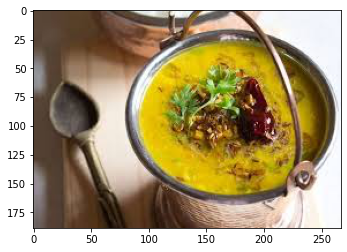

In [ ]:
# Show original picture

img_path = '/content/drive/My Drive/Naaniz/test/1.jpg' 

with Image.open(img_path) as image:
    plt.imshow(image)

# **Class Prediction**
Once you load the checkpoints, it's time to write a function for making predictions with your model. A common practice is to predict the top 6 or so (usually called top- K ) most probable classes. You'll want to calculate the class probabilities then find the  K  largest values.


Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

In [ ]:
def predict(image_path, model, topk=6):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    # move the model to cuda
    cuda = torch.cuda.is_available()
    if cuda:
        # Move model parameters to the GPU
        model.cuda()
        print("Number of GPUs:", torch.cuda.device_count())
        print("Device name:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("We go for CPU")
    
    # turn off dropout
    model.eval()

    # The image
    image = process_image(image_path)
    
    # tranfer to tensor
    image = torch.from_numpy(np.array([image])).float()
    
    # The image becomes the input
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data
    
    # getting the topk (=5) probabilites and indexes
    # 0 -> probabilities
    # 1 -> index
    prob = torch.topk(probabilities, topk)[0].tolist()[0] # probabilities
    index = torch.topk(probabilities, topk)[1].tolist()[0] # index
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    # transfer index to label
    label = []
    for i in range(6):
        label.append(ind[index[i]])

    return prob, label

Number of GPUs: 1
Device name: Tesla T4
[0.6269381046295166, 0.15328727662563324, 0.04798150435090065, 0.02926654741168022, 0.025492142885923386, 0.02222474291920662]
['Halwa', 'Rogan_josh', 'Gajar_Halwa', 'Indian_pickle', 'Paneer_tikka_masala', 'Mutton_curry']
['126', '205', '29', '174', '176', '166']


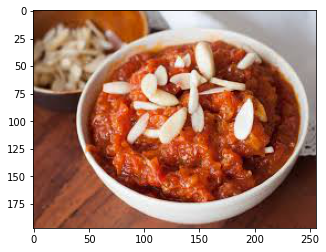

In [ ]:
#img = random.choice(os.listdir('/content/drive/My Drive/Car Brand/Datasets/valid/aud
img_path = '/content/drive/My Drive/Naaniz/test3/1.jpg' 

with Image.open(img_path) as image:
    plt.imshow(image)
with  Image.open(img_path) as image:
    plt.imshow(image)
prob, classes = predict(img_path, model)
print(prob)
print(classes)
print([cat_to_name[x] for x in classes])

# **Sanity Checking**
Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use matplotlib to plot the probabilities for the top 6 classes as a bar graph, along with the input image. It should look like this:

Number of GPUs: 1
Device name: Tesla T4


ValueError: ignored

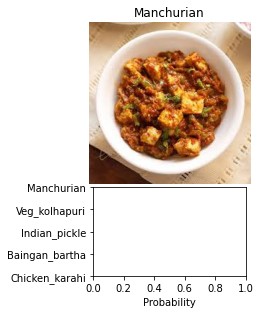

In [ ]:
img_path = '/content/drive/My Drive/Naaniz/test/11.jpg' 
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
label = classes[max_index]
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)
image = Image.open(img_path)
ax1.axis('off') 
ax1.set_title(label)  
ax1.imshow(image)
labels = []
for cl in classes:
    labels.append(cl)   
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='blue')
plt.show()

  # **Thank you for Giving your valuable time in this Repositroies**